In [1]:
import h2o
import operator
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
from matplotlib import pyplot as plt
import warnings
from plot.ice import ice, ice_plot
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators import H2OGradientBoostingEstimator
warnings.filterwarnings("ignore")
from h2o.estimators.random_forest import H2ORandomForestEstimator
from IPython.display import Image, display
from h2o.backend import H2OLocalServer
import subprocess
%matplotlib inline

# 1 Data Preparation

## 1.1 H2O Initialization

In [2]:
pct_memory=4
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

48


In [3]:
h2o.init(strict_version_check=False,max_mem_size=min_mem_size)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/5l/qqvypzcs2sjbbnhb777lxczh0000gn/T/tmpr6a9c9xj
  JVM stdout: /var/folders/5l/qqvypzcs2sjbbnhb777lxczh0000gn/T/tmpr6a9c9xj/h2o_mandy_started_from_python.out
  JVM stderr: /var/folders/5l/qqvypzcs2sjbbnhb777lxczh0000gn/T/tmpr6a9c9xj/h2o_mandy_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.2
H2O cluster version age:,"7 days, 12 hours and 14 minutes"
H2O cluster name:,H2O_from_python_mandy_zm4qb4
H2O cluster total nodes:,1
H2O cluster free memory:,42.67 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"accepting new members, healthy"


## 1.2 Data Import & Parse

In [4]:
data_path = "data/AmazonReviews.Small.csv"

# Load data into H2O
reviews = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [5]:
reviews.shape

(55554, 10)

In [6]:
reviews.head(3)

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one."
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring."
B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1.3106e+09,"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)"


In [7]:
reviews['PositiveReview']=(reviews['Score']>=reviews['Score'].mean()[0]).ifelse('1','0')

In [8]:
reviews['PositiveReview'].table()

PositiveReview,Count
0,20106
1,35448


In [9]:
# Find the 80th quantile of time in the dataset
time_split = reviews["Time"].quantile(prob = [0.8])[1]
reviews["Train"] = (reviews["Time"] < time_split).ifelse("Yes", "No")

In [10]:
reviews['Train'].table()

Train,Count
No,11152
Yes,44402


In [11]:
train = reviews[reviews["Train"] == "Yes"]
test = reviews[reviews["Train"] == "No"]

## 1.3 Tokenize Words in Review

In [12]:
data_path = "data/stopwords.csv"
STOP_WORDS = pd.read_csv(data_path, header=0)

In [13]:
STOP_WORDS.head()

,STOP_WORD
0,all
1,just
2,being
3,over
4,both


In [14]:
STOP_WORDS = list(STOP_WORDS['STOP_WORD'])

In [15]:
def tokenize(sentences, stop_word = STOP_WORDS):
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(STOP_WORDS)),:]
    return tokenized_words

In [16]:
# Break reviews into sequence of words
words = tokenize(reviews["Text"])

In [17]:
words.head()

C1
made
china
buy
pet
food
china
dogswell
using
propylene
glycol


## 1.4 Word2Vec Model

In [18]:
# Train Word2Vec Model
from h2o.estimators.word2vec import H2OWord2vecEstimator

w2v_model = H2OWord2vecEstimator(vec_size = 100, model_id = "w2v.hex")
w2v_model.train(training_frame=words)

models_path='data'
h2o.save_model(w2v_model, path = models_path, force = True)

word2vec Model Build progress: |██████████████████████████████████████████| 100%


'/Users/mandy/Documents/Study/AI-Addin/data/w2v.hex'

In [19]:
# Sanity check - find synonyms for the word 'coffee'
w2v_model.find_synonyms("coffee", count = 5)

OrderedDict([('coffe', 0.7880265712738037),
             ('coffees', 0.775317907333374),
             ('expresso', 0.770995020866394),
             ('brew', 0.7658652067184448),
             ('espresso', 0.7608984112739563)])

In [20]:
# Sanity check - find synonyms for the word 'stale'
w2v_model.find_synonyms("stale", count = 5)

OrderedDict([('unedible', 0.6775936484336853),
             ('inedible', 0.6553192734718323),
             ('staleness', 0.652902364730835),
             ('rancid', 0.6427142024040222),
             ('tasteless', 0.6288880705833435)])

In [21]:
# Calculate a vector for each review
review_vecs = w2v_model.transform(words, aggregate_method = "AVERAGE")
review_vecs

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
0.0295094,0.066233,-0.16832,-0.00718203,0.148106,-0.103091,0.0670702,-0.257149,0.158398,-0.0344804,-0.0683857,-0.239267,0.0943008,0.217501,0.150865,-0.00831982,0.071854,-0.00527484,-0.0302876,-0.109363,-0.0349179,0.0376678,-0.0338961,-0.0774556,0.13139,0.0423277,0.133431,-0.115538,-0.158186,0.0158561,0.121881,0.106072,0.273432,-0.0417101,0.0415352,-0.0398789,0.141539,-0.0807481,-0.0285375,-0.266911,0.0521544,-0.178451,0.0420627,-0.0707194,-0.07424,-0.0148047,-0.214717,-0.0413866,-0.001777,-0.0742207,0.0390356,-0.126243,-0.00535087,0.0852163,-0.033692,-0.0678786,0.059397,0.12507,0.148764,-0.0299464,-0.144768,0.206505,-0.172826,-0.101001,0.0745772,0.0539195,-0.103948,-0.0172267,0.0260809,0.0830391,0.00921713,-0.118752,0.162302,-0.108317,-0.127868,0.120726,0.13434,0.143518,0.0567974,-0.173195,0.0186925,-0.0662419,0.107606,-0.0526973,-0.0488834,-0.0704067,0.10074,0.106776,0.0608806,0.0595027,-0.0325755,0.075663,-0.0565232,-0.0887184,0.0096202,-0.0494941,0.0843488,-0.0387162,0.0871634,-0.0481808
0.116133,0.178062,-0.0303227,-0.0343458,-0.0381563,-0.00405123,-0.0123417,-0.179899,0.00914147,0.00714435,0.136036,-0.00672298,-0.0988181,-0.00547016,0.113726,0.117924,0.0920578,-0.0217227,-0.131503,-0.113609,0.221722,0.0356896,-0.0587838,-0.0100369,0.244295,-0.118097,0.0526805,-0.111097,-0.205012,-0.105371,0.090082,0.0162477,0.120524,0.0579957,-0.107262,0.0721207,0.0483247,-0.157904,-0.115989,-0.129712,0.0191399,0.0147708,0.0974053,-0.127857,-0.0344802,-0.0499029,-0.107263,0.0460666,-0.00795888,-0.0503963,0.0411857,-0.0446381,0.0707444,0.111923,0.117387,0.0415253,-0.0859307,0.105671,0.0923947,-0.0945489,-0.028047,0.0652924,-0.17937,-0.153881,-0.045264,-0.107552,-0.175311,-0.107735,0.0485833,-0.0152083,-0.116038,0.00720263,0.110973,0.0985583,-0.0886316,0.168493,0.14848,0.132078,0.0399205,0.00168938,0.0323981,0.0121825,-0.0529265,-0.0852969,0.00439495,0.0115318,0.0434489,0.0605051,-0.0777502,0.421383,-0.0575506,0.010264,-0.183074,0.0901465,0.147647,-0.0728932,-0.0855785,-0.0119661,0.161623,0.226833
-0.0764664,0.00307814,0.0743165,0.129827,0.0705044,-0.0136083,-0.0758186,-0.417794,0.144915,0.0592352,0.0351221,-0.131135,0.0279823,0.180498,0.133293,-0.0154095,0.174515,-0.075433,-0.0862052,-0.155679,0.0540325,-0.0370713,0.0811474,-0.12833,0.197839,0.035483,0.124575,-0.0794659,-0.16046,-0.0683376,-0.0062757,0.12275,0.270114,0.019029,-0.111103,-0.0458377,0.0726666,-0.0519836,-0.0133064,-0.149349,0.0431801,-0.0996685,-0.0184828,-0.00667976,0.0162896,-0.0845204,-0.163519,-0.0317914,-0.0721107,-0.107298,0.150619,-0.0808622,-0.0276897,0.0447547,-0.0614478,-0.0679796,-0.0631454,0.092712,0.0689115,-0.160815,-0.110896,0.0720307,-0.100787,-0.161882,-0.0644515,0.0121939,-0.0924015,-0.0773338,-0.00285366,0.0302828,-0.00561952,-0.058282,0.100089,-0.022957,-0.0522131,0.0130081,0.117849,-0.0115698,0.0289642,-0.0492316,-0.0591898,0.0203703,-0.0781194,0.0109109,-0.101759,-0.112229,0.178296,0.13506,-0.0596499,0.117099,0.0409004,-0.000845579,-0.0582646,0.0251877,0.117819,0.0468479,0.109896,-0.0781398,0.0960545,0.104001
0.125511,0.0998658,0.0489562,0.12795,0.0582601,-0.128244,0.0433429,-0.30279,0.156163,0.0571509,0.0418139,-0.078255,-0.013608,0.0630363,0.0437115,0.0130793,0.148464,-0.0849577,0.0111989,-0.154456,0.0781887,-0.119378,0.00170365,-0.111023,0.0694944,0.0894273,0.0638208,-0.0965128,-0.225892,-0.12736,-0.038228,0.0948964,0.329422,-0.110802,-0.204079,0.0549727,0.0697659,-0.0663924,-0.127788,-0.271954,0.00649616,-0.0747967,-0.00420114,0.00184971,-0.0483064,-0.0738908,-0.128279,-0.00886446,0.0522541,-0.0213437,0.0381699,-0.0621644,-0.066642,0.119886,0.130286,-0.020568,-0.038

In [22]:
# Add aggregated word embeddings 
ext_reviews = reviews.cbind(review_vecs)

In [23]:
ext_reviews.head(3)

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,PositiveReview,Train,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one.",0,No,0.0295094,0.066233,-0.16832,-0.00718203,0.148106,-0.103091,0.0670702,-0.257149,0.158398,-0.0344804,-0.0683857,-0.239267,0.0943008,0.217501,0.150865,-0.00831982,0.071854,-0.00527484,-0.0302876,-0.109363,-0.0349179,0.0376678,-0.0338961,-0.0774556,0.13139,0.0423277,0.133431,-0.115538,-0.158186,0.0158561,0.121881,0.106072,0.273432,-0.0417101,0.0415352,-0.0398789,0.141539,-0.0807481,-0.0285375,-0.266911,0.0521544,-0.178451,0.0420627,-0.0707194,-0.07424,-0.0148047,-0.214717,-0.0413866,-0.001777,-0.0742207,0.0390356,-0.126243,-0.00535087,0.0852163,-0.033692,-0.0678786,0.059397,0.12507,0.148764,-0.0299464,-0.144768,0.206505,-0.172826,-0.101001,0.0745772,0.0539195,-0.103948,-0.0172267,0.0260809,0.0830391,0.00921713,-0.118752,0.162302,-0.108317,-0.127868,0.120726,0.13434,0.143518,0.0567974,-0.173195,0.0186925,-0.0662419,0.107606,-0.0526973,-0.0488834,-0.0704067,0.10074,0.106776,0.0608806,0.0595027,-0.0325755,0.075663,-0.0565232,-0.0887184,0.0096202,-0.0494941,0.0843488,-0.0387162,0.0871634,-0.0481808
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring.",0,Yes,0.116133,0.178062,-0.0303227,-0.0343458,-0.0381563,-0.00405123,-0.0123417,-0.179899,0.00914147,0.00714435,0.136036,-0.00672298,-0.0988181,-0.00547016,0.113726,0.117924,0.0920578,-0.0217227,-0.131503,-0.113609,0.221722,0.0356896,-0.0587838,-0.0100369,0.244295,-0.118097,0.0526805,-0.111097,-0.205012,-0.105371,0.090082,0.0162477,0.120524,0.0579957,-0.107262,0.0721207,0.0483247,-0.157904,-0.115989,-0.129712,0.0191399,0.0147708,0.0974053,-0.127857,-0.0344802,-0.0499029,-0.107263,0.0460666,-0.00795888,-0.0503963,0.0411857,-0.0446381,0.0707444,0.111923,0.117387,0.0415253,-0.0859307,0.105671,0.0923947,-0.0945489,-0.028047,0.0652924,-0.17937,-0.153881,-0.045264,-0.107552,-0.175311,-0.107735,0.0485833,-0.0152083,-0.116038,0.00720263,0.110973,0.0985583,-0.0886316,0.168493,0.14848,0.132078,0.0399205,0.00168938,0.0323981,0.0121825,-0.0529265,-0.0852969,0.00439495,0.0115318,0.0434489,0.0605051,-0.0777502,0.421383,-0.0575506,0.010264,-0.183074,0.0901465,0.147647,-0.0728932,-0.0855785,-0.0119661,0.161623,0.226833
B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1.3106e+09,"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)",1,Yes,-0.0764664,0.00307814,0.0743165,0.129827,0.0705044,-0.0136083,-0.0758186,-0.417794,0.144915,0.0592352,0.0351221,-0.131135,0.0279823,0.180498,0.133293,-0.0154095,0.174515,-0.075433,-0.0862052,-0.155679,0.0540325,-0.0370713,0.0811474,-0.12833,0.197839,0.035483,0.124575,-0.0794659,-0.16046,-0.0683376,-0.0062757,0.12275,0.270114,0.019029,-0.111103,-0.0458377,0.0726666,-0.0519836,-0.0133064,-0.149349,0.043180

## 1.5 Add Summary Column

In [24]:
# Break summaries into sequence of word.
summary_words = tokenize(reviews['Summary'].ascharacter())

In [25]:
summary_vecs = w2v_model.transform(summary_words, aggregate_method='AVERAGE')
summary_vecs.names = ['summary_'+ s for s in summary_vecs.names]

ext_reviews_new = ext_reviews.cbind(summary_vecs)

In [26]:
ext_reviews_new.head(3)

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,PositiveReview,Train,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100,summary_C1,summary_C2,summary_C3,summary_C4,summary_C5,summary_C6,summary_C7,summary_C8,summary_C9,summary_C10,summary_C11,summary_C12,summary_C13,summary_C14,summary_C15,summary_C16,summary_C17,summary_C18,summary_C19,summary_C20,summary_C21,summary_C22,summary_C23,summary_C24,summary_C25,summary_C26,summary_C27,summary_C28,summary_C29,summary_C30,summary_C31,summary_C32,summary_C33,summary_C34,summary_C35,summary_C36,summary_C37,summary_C38,summary_C39,summary_C40,summary_C41,summary_C42,summary_C43,summary_C44,summary_C45,summary_C46,summary_C47,summary_C48,summary_C49,summary_C50,summary_C51,summary_C52,summary_C53,summary_C54,summary_C55,summary_C56,summary_C57,summary_C58,summary_C59,summary_C60,summary_C61,summary_C62,summary_C63,summary_C64,summary_C65,summary_C66,summary_C67,summary_C68,summary_C69,summary_C70,summary_C71,summary_C72,summary_C73,summary_C74,summary_C75,summary_C76,summary_C77,summary_C78,summary_C79,summary_C80,summary_C81,summary_C82,summary_C83,summary_C84,summary_C85,summary_C86,summary_C87,summary_C88
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one.",0,No,0.0295094,0.066233,-0.16832,-0.00718203,0.148106,-0.103091,0.0670702,-0.257149,0.158398,-0.0344804,-0.0683857,-0.239267,0.0943008,0.217501,0.150865,-0.00831982,0.071854,-0.00527484,-0.0302876,-0.109363,-0.0349179,0.0376678,-0.0338961,-0.0774556,0.13139,0.0423277,0.133431,-0.115538,-0.158186,0.0158561,0.121881,0.106072,0.273432,-0.0417101,0.0415352,-0.0398789,0.141539,-0.0807481,-0.0285375,-0.266911,0.0521544,-0.178451,0.0420627,-0.0707194,-0.07424,-0.0148047,-0.214717,-0.0413866,-0.001777,-0.0742207,0.0390356,-0.126243,-0.00535087,0.0852163,-0.033692,-0.0678786,0.059397,0.12507,0.148764,-0.0299464,-0.144768,0.206505,-0.172826,-0.101001,0.0745772,0.0539195,-0.103948,-0.0172267,0.0260809,0.0830391,0.00921713,-0.118752,0.162302,-0.108317,-0.127868,0.120726,0.13434,0.143518,0.0567974,-0.173195,0.0186925,-0.0662419,0.107606,-0.0526973,-0.0488834,-0.0704067,0.10074,0.106776,0.0608806,0.0595027,-0.0325755,0.075663,-0.0565232,-0.0887184,0.0096202,-0.0494941,0.0843488,-0.0387162,0.0871634,-0.0481808,-0.106639,-0.167436,0.153167,0.170073,0.125219,-0.053732,0.0636633,-0.025894,0.0292892,-0.0426846,-0.0827588,-0.243347,0.0803598,-0.104493,0.0880019,-0.0342808,0.223435,-0.088957,-0.0751616,-0.173052,0.0835043,0.0742668,-0.0724772,-0.0682212,0.290643,-0.0646061,0.211007,-0.132549,-0.300928,0.0363331,0.211927,0.150988,0.208618,0.0517759,0.0939559,0.00422468,0.181516,-0.0661127,-0.194067,-0.316077,0.184331,-0.0372453,-0.0503869,0.0698041,-0.0465051,0.239691,-0.0688175,0.176988,0.16702,0.0289307,0.198723,-0.149893,-0.049574,0.110562,-0.399997,-0.251823,0.0171382,0.185547,0.319788,-0.142664,0.0620862,0.092732,-0.115211,0.0887503,-0.070829,-0.351754,-0.0886859,-0.0982121,-0.126295,-0.0544754,0.138328,-0.27596,0.0983795,-0.100898,-0.257825,0.323225,0.433518,-0.0908136,0.411052,0.0970343,0.222817,0.00755737,-0.0150321,0.152891,-0.14236,0.190374,0.0557401,-0.0813378
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it j

In [27]:
ext_train_new = ext_reviews_new[ext_reviews_new["Train"] == "Yes"]
ext_test_new = ext_reviews_new[ext_reviews_new["Train"] == "No"]

In [28]:
ext_test_simple = ext_test_new.drop([2, 6, 9])

In [29]:
predictors = ['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time'] + summary_vecs.names + review_vecs.names 
response = 'PositiveReview'

# 2 Training Models

## 2.1 Linear Regression

### 2.1.1 Train & Fit Model

In [31]:
# Initialize
local_glm_plus = H2OGeneralizedLinearEstimator(family='binomial', model_id='glm_surrogate', lambda_search=True)
# train 
local_glm_plus.train(x=predictors, y=response, training_frame=ext_train_new)

glm Model Build progress: |███████████████████████████████████████████████| 100%


### 2.1.2 Interpretability

#### Variable Importance

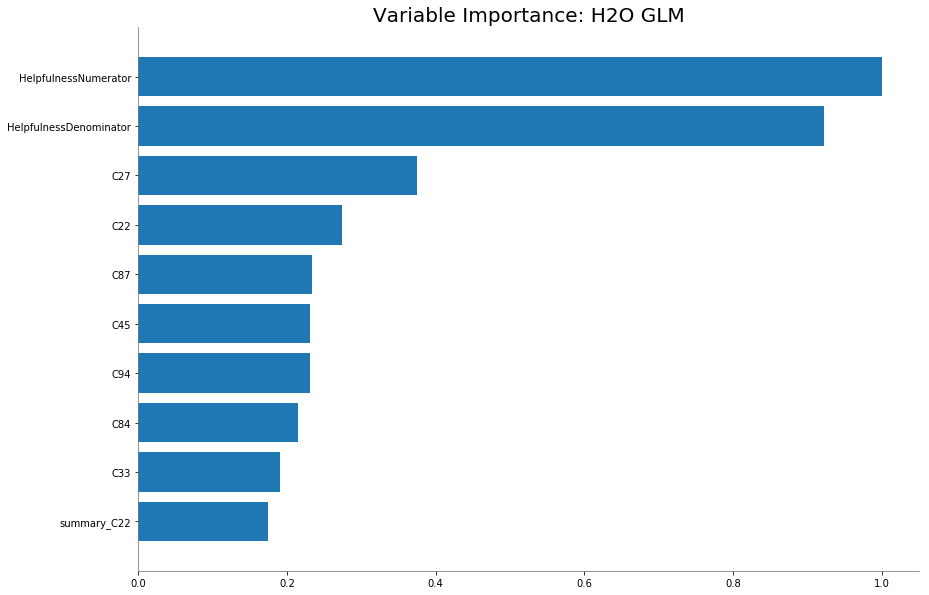

In [32]:
local_glm_plus.varimp_plot()

#### Partial Dependence Plot (PDP)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


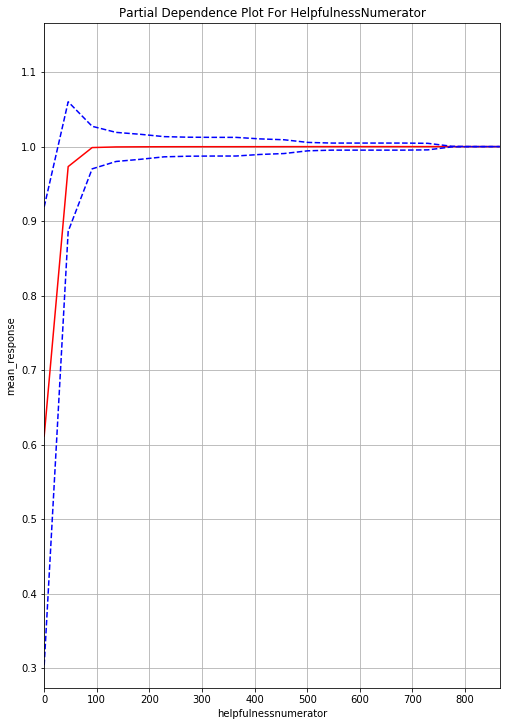

In [33]:
pdp_local_linear_plus = local_glm_plus.partial_plot(data = ext_train_new, cols = ["HelpfulnessNumerator"])

#### Individual Conditional Expectation (ICE)

In [36]:
HelpfulnessNumerator_ice_df = ice(data=ext_test_simple, column='HelpfulnessNumerator', model=local_glm_plus)

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


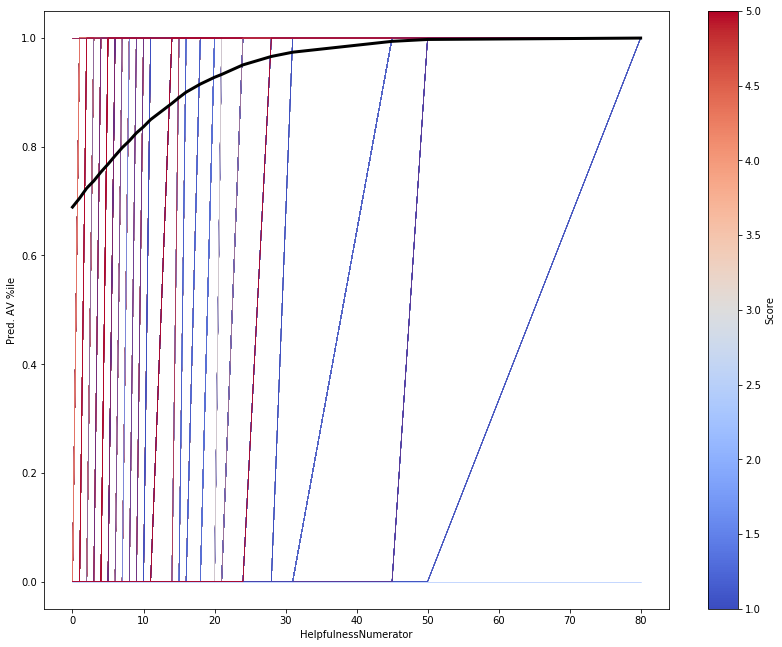

In [37]:
ice_plot(HelpfulnessNumerator_ice_df, linewidth=0.5, color_by='Score', cmap='coolwarm',
        plot_pdp=True, pdp_kwargs={'c': 'k', 'linewidth': 3})
vals = HelpfulnessNumerator_ice_df.columns.get_level_values('Score').values
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vals.min(), vmax=vals.max()))
sm._A = []
plt.colorbar(sm, label='Score')
plt.ylabel('Pred. AV %ile')
plt.xlabel('HelpfulnessNumerator');

### 2.1.3 Matrix

In [38]:
print('\nLocal GLM Coefficients:')
for c_name, c_val in sorted(local_glm_plus.coef().items(), key=operator.itemgetter(1)):
    if c_val != 0.0:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))


Local GLM Coefficients:
C22:                      -4.155718056036148
C94:                      -3.822656045453817
C84:                      -3.554480200551809
C45:                      -3.484780414402958
C87:                      -3.2659876391740936
C33:                      -2.8022493523158962
C38:                      -2.0773759422828246
C21:                      -2.007971609696023
C98:                      -1.984763353305128
C6:                       -1.665357154546245
C95:                      -1.6477907545644048
C65:                      -1.554108975266539
C49:                      -1.4925166631376823
C16:                      -1.3363694980537446
C19:                      -1.2090762815457876
summary_C22:              -1.16746623542772
C59:                      -1.10997379784825
C69:                      -1.054647994249894
C73:                      -1.0234681768601919
C31:                      -1.012770129647702
C60:                      -1.0091230403460485
C32:                   

In [39]:
local_glm_plus.r2(train=True, valid=True)

{'train': 0.42846638133703263, 'valid': None}

In [40]:
local_glm_plus.auc()

0.8749329925231295

In [41]:
local_glm_plus.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45739478619057256: 


,0,1,Error,Rate
0,9981.0,5913.0,0.372,(5913.0/15894.0)
1,2226.0,26282.0,0.0781,(2226.0/28508.0)
Total,12207.0,32195.0,0.1833,(8139.0/44402.0)


## 2.2 Logistic Regression

### 2.2.1 Train & Fit Model

In [32]:
glm_logistic_plus_summary = H2OGeneralizedLinearEstimator(family = "binomial")
glm_logistic_plus_summary.train(x=predictors, 
                               y= response, 
                               training_frame = ext_train_new, 
                               validation_frame = ext_test_new, 
                               model_id="glm_logistic")

glm Model Build progress: |███████████████████████████████████████████████| 100%


### 2.2.2 Interpretability

#### Variable Importance

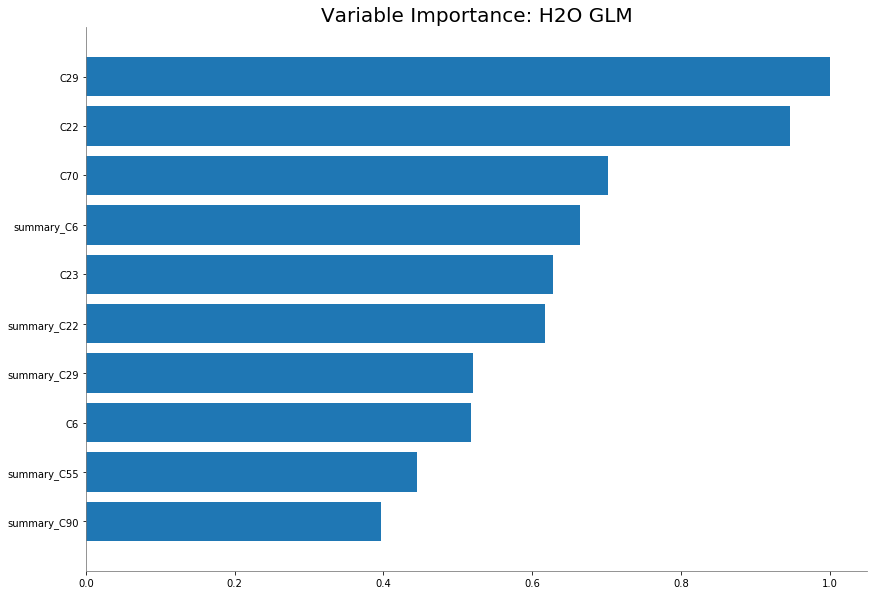

In [33]:
glm_logistic_plus_summary.varimp_plot()

#### Partial Dependence Plot (PDP)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


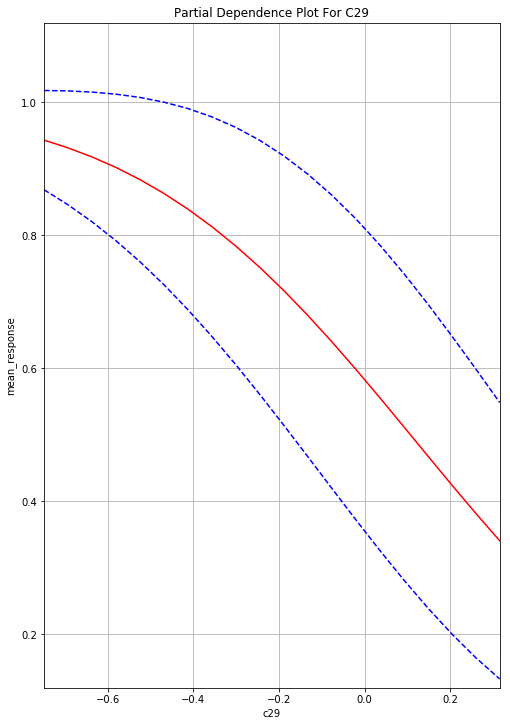

In [68]:
pdp_word_vecs = glm_logistic_plus_summary.partial_plot(data = ext_train_new, cols = ["C29"])

#### Individual Conditional Expectation (ICE)

In [40]:
ext_test_simple_lice = ext_test_simple.sort('C29')

In [64]:
ext_test_simple_lices = h2o.H2OFrame(ext_test_simple_lice.as_data_frame().iloc[::25])

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [65]:
ext_test_simple_lices.shape

(447, 209)

In [66]:
C29_ice_df = ice(data=ext_test_simple_lices, column='C29', model=glm_logistic_plus_summary)

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


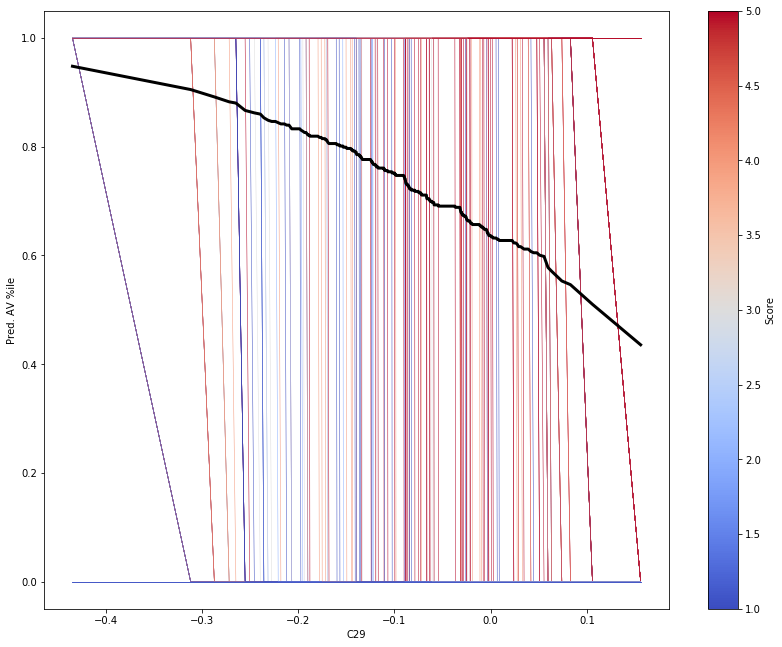

In [67]:
ice_plot(C29_ice_df, linewidth=0.5, color_by='Score', cmap='coolwarm',
        plot_pdp=True, pdp_kwargs={'c': 'k', 'linewidth': 3})
vals = C29_ice_df.columns.get_level_values('Score').values
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vals.min(), vmax=vals.max()))
sm._A = []
plt.colorbar(sm, label='Score')
plt.ylabel('Pred. AV %ile')
plt.xlabel('C29');

### 2.2.3 Matrix

In [51]:
print("With Summary and Review Embeddings AUC: " + str(round(glm_logistic_plus_summary.auc(valid = True), 3)))

With Summary and Review Embeddings AUC: 0.854


In [52]:
glm_logistic_plus_summary.confusion_matrix(valid = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4744080370497271: 


,0,1,Error,Rate
0,2454.0,1758.0,0.4174,(1758.0/4212.0)
1,572.0,6368.0,0.0824,(572.0/6940.0)
Total,3026.0,8126.0,0.2089,(2330.0/11152.0)


In [53]:
glm_logistic_plus_summary.confusion_matrix(valid = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4744080370497271: 


,0,1,Error,Rate
0,2454.0,1758.0,0.4174,(1758.0/4212.0)
1,572.0,6368.0,0.0824,(572.0/6940.0)
Total,3026.0,8126.0,0.2089,(2330.0/11152.0)


## 2.3 Decision Tree

### 2.3.1 Train & Fit Model

In [45]:
# initialize single tree surrogate model
model_id = 'dt_surrogate_mojo'

# train single tree surrogate model
surrogate = H2OGradientBoostingEstimator(ntrees=1,
                                         sample_rate=1,
                                         col_sample_rate=1,
                                         max_depth=3,
                                         seed=12345,
                                         model_id=model_id)

_ = surrogate.train(x=predictors, y=response, training_frame=ext_train_new)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [46]:
# persist MOJO (compiled, representation of trained model)
# from which to generate plot of surrogate
mojo_path = surrogate.download_mojo(path='data')

print(surrogate)
print('Generated MOJO path:\n', mojo_path)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  dt_surrogate_mojo


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.22484148909893112
RMSE: 0.47417453442686175
LogLoss: 0.641473474981203
Mean Per-Class Error: 0.35673493790920763
AUC: 0.6864312338888747
pr_auc: 0.49617961954787737
Gini: 0.37286246777774945
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6237288109631749: 


,0,1,Error,Rate
0,2513.0,13381.0,0.8419,(13381.0/15894.0)
1,928.0,27580.0,0.0326,(928.0/28508.0)
Total,3441.0,40961.0,0.3223,(14309.0/44402.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.6237288,0.7940232,6.0
max f2,0.6040157,0.8996806,7.0
max f0point5,0.6456974,0.7483732,3.0
max accuracy,0.6288379,0.6889104,4.0
max precision,0.6595294,0.8189030,0.0
max recall,0.6040157,1.0,7.0
max specificity,0.6595294,0.8664276,0.0
max absolute_mcc,0.6456974,0.2991284,3.0
max min_per_class_accuracy,0.6468971,0.6062509,1.0
max mean_per_class_accuracy,0.6456974,0.6432651,3.0


Gains/Lift Table: Avg response rate: 64.20 %, avg score: 64.19 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.2640196,0.6595294,1.2754641,1.2754641,0.8189030,0.6595294,0.8189030,0.6595294,0.3367476,0.3367476,27.5464133,27.5464133
,2,0.5145264,0.6468971,1.0758325,1.1782698,0.6907309,0.6468971,0.7565000,0.6533791,0.2695033,0.6062509,7.5832546,17.8269782
,3,0.6978064,0.6456974,1.0591495,1.1469826,0.6800197,0.6458318,0.7364123,0.6513968,0.1941209,0.8003718,5.9149466,14.6982630
,4,0.7437728,0.6288379,0.7959341,1.1252872,0.5110240,0.6288379,0.7224830,0.6500026,0.0365862,0.8369580,-20.4065947,12.5287243
,5,0.8082969,0.6259592,0.7518537,1.0954771,0.4827225,0.6259592,0.7033435,0.6480833,0.0485127,0.8854707,-24.8146309,9.5477069
,6,0.9225035,0.6237288,0.7177958,1.0487199,0.4608558,0.6237288,0.6733234,0.6450682,0.0819770,0.9674477,-28.2204247,4.8719862
,7,1.0,0.6040157,0.4200482,1.0,0.2696890,0.6040157,0.6420432,0.6418868,0.0325523,1.0,-57.9951841,0.0



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-04-24 13:44:26,0.006 sec,0.0,0.4793994,0.6522336,0.5,0.0,1.0,0.3579568
,2019-04-24 13:44:26,0.206 sec,1.0,0.4741745,0.6414735,0.6864312,0.4961796,1.2754641,0.3222603


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
summary_C42,405.0216675,1.0,0.3503245
C26,249.8122711,0.6167874,0.2160757
summary_C54,248.7382355,0.6141356,0.2151468
summary_C97,116.3464890,0.2872599,0.1006342
C22,74.6155167,0.1842260,0.0645389
---,---,---,---
summary_C95,0.0,0.0,0.0
summary_C96,0.0,0.0,0.0
summary_C98,0.0,0.0,0.0
summary_C99,0.0,0.0,0.0



See the whole table with table.as_data_frame()

Generated MOJO path:
 /Users/mandy/Documents/Study/AI-Addin/data/dt_surrogate_mojo.zip


In [47]:
details = False # print more info on tree, details = True
title = 'Amazon Reviews Decision Tree Surrogate'

hs = H2OLocalServer()
h2o_jar_path = hs._find_jar()
print('Discovered H2O jar path:\n', h2o_jar_path)

gv_file_name = model_id + '.gv'
gv_args = str('-cp ' + h2o_jar_path +
              ' hex.genmodel.tools.PrintMojo --tree 0 -i '
              + mojo_path + ' -o').split()
gv_args.insert(0, 'java')
gv_args.append(gv_file_name)

if details:
    gv_args.append('--detail')

if title is not None:
    gv_args = gv_args + ['--title', title]
    
print()
print('Calling external process ...')
print(' '.join(gv_args))
    
_ = subprocess.call(gv_args)

Discovered H2O jar path:
 /anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /Users/mandy/Documents/Study/AI-Addin/data/dt_surrogate_mojo.zip -o dt_surrogate_mojo.gv --title Amazon Reviews Decision Tree Surrogate


In [48]:
png_file_name = model_id + '.png'
png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
png_args = png_args.split()

print('Calling external process ...')
print(' '.join(png_args))

_ = subprocess.call(png_args)

Calling external process ...
dot -Tpng dt_surrogate_mojo.gv -o dt_surrogate_mojo.png


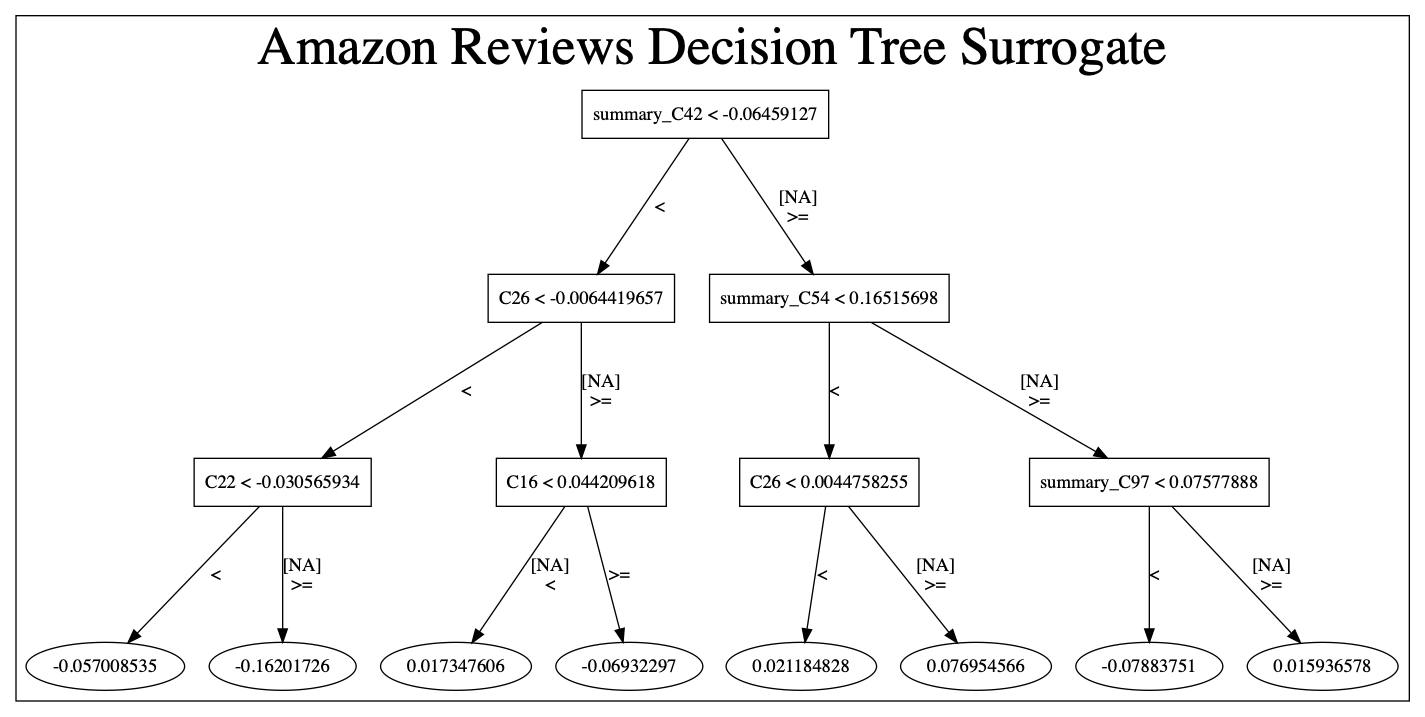

In [49]:
display(Image((png_file_name)))

### 2.3.2 Interpretability

#### Variable Importance

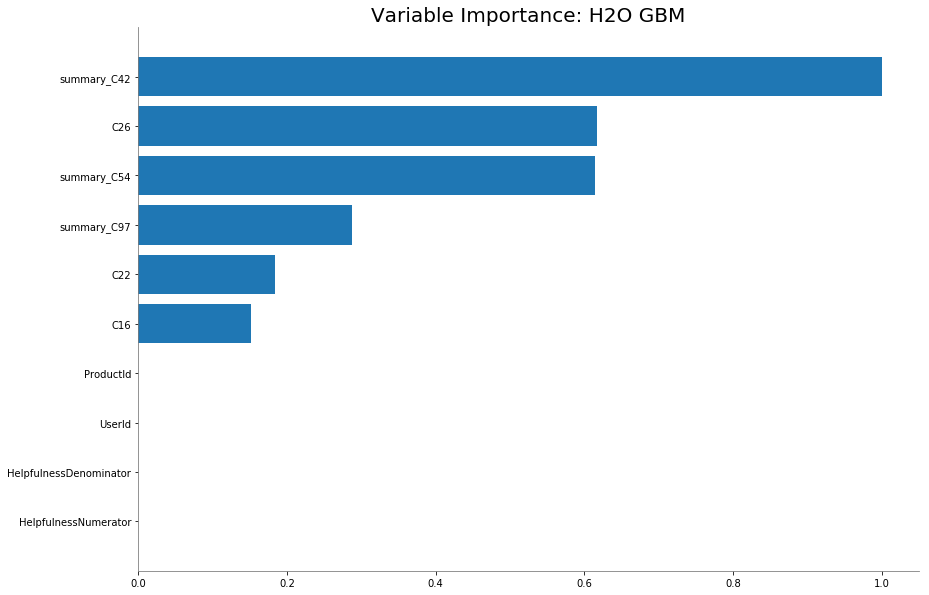

In [50]:
surrogate.varimp_plot()

#### Partial Dependence Plot (PDP)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


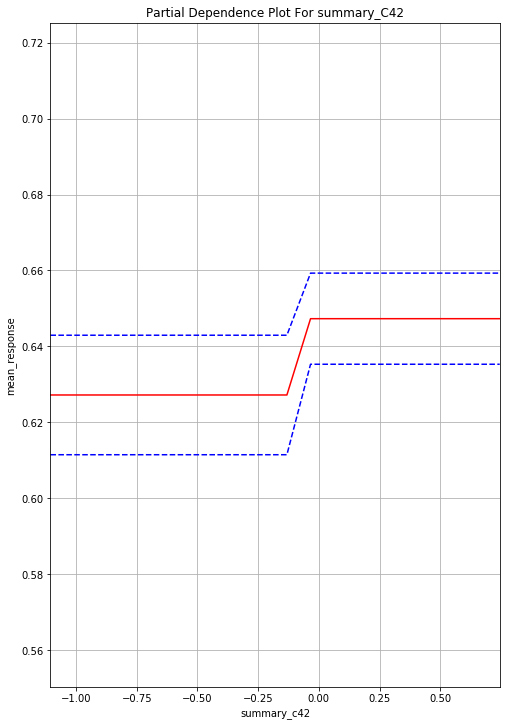

In [40]:
pdp_word_vecs = surrogate.partial_plot(data = ext_train_new, cols = ["summary_C42"])

#### Individual Conditional Expectation (ICE)

In [41]:
ext_test_simple_dice = ext_test_simple.sort('summary_C42')

In [42]:
ext_test_simple_dices = h2o.H2OFrame(ext_test_simple_dice.as_data_frame().iloc[::20])

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [43]:
ext_test_simple_dices.shape

(558, 209)

In [44]:
summary_C42_ice_df = ice(data=ext_test_simple_dices, column='summary_C42', model=surrogate)

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: | (failed)


OSError: Job with key $03017f00000132d4ffffffff$_91be45236581dd75d9127db6fa7d47ac failed with an exception: java.lang.IllegalArgumentException: Test/Validation dataset has categorical column 'summary_C1' which is real-valued in the training data
stacktrace: 
java.lang.IllegalArgumentException: Test/Validation dataset has categorical column 'summary_C1' which is real-valued in the training data
	at hex.Model.adaptTestForTrain(Model.java:1255)
	at hex.Model.adaptTestForTrain(Model.java:1111)
	at hex.Model.score(Model.java:1379)
	at water.api.ModelMetricsHandler$1.compute2(ModelMetricsHandler.java:377)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1416)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.ForkJoinTask.doExec(ForkJoinTask.java:263)
	at jsr166y.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:974)
	at jsr166y.ForkJoinPool.runWorker(ForkJoinPool.java:1477)
	at jsr166y.ForkJoinWorkerThread.run(ForkJoinWorkerThread.java:104)


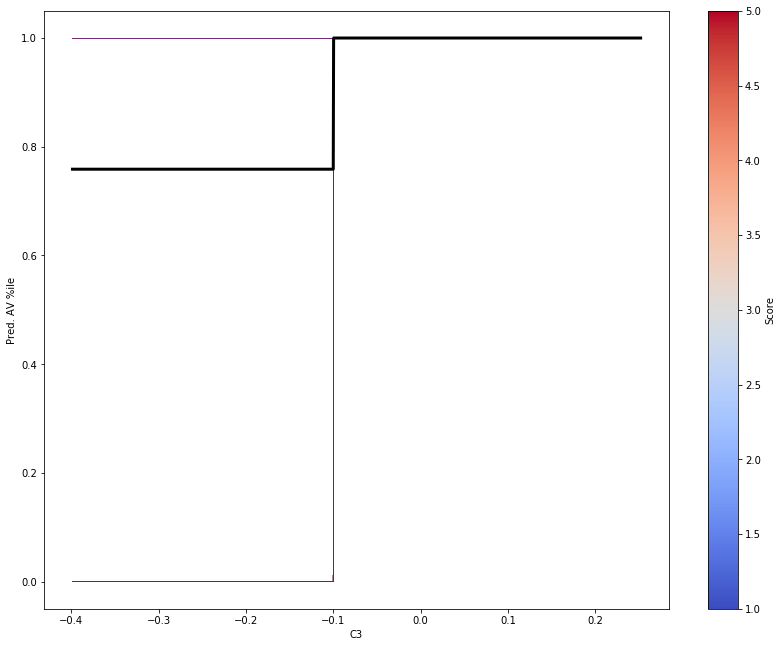

In [48]:
ice_plot(C26_ice_df, linewidth=0.5, color_by='Score', cmap='coolwarm',
        plot_pdp=True, pdp_kwargs={'c': 'k', 'linewidth': 3})
vals = C26_ice_df.columns.get_level_values('Score').values
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vals.min(), vmax=vals.max()))
sm._A = []
plt.colorbar(sm, label='Score')
plt.ylabel('Pred. AV %ile')
plt.xlabel('C26');

### 2.3.3 Matrix

In [76]:
print(surrogate)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  dt_surrogate_mojo


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.22490468188680712
RMSE: 0.4742411642685682
LogLoss: 0.6415846447228967
Mean Per-Class Error: 0.35615213187394557
AUC: 0.692578222817862
pr_auc: 0.42284625175470336
Gini: 0.38515644563572393
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6287949244602625: 


,0,1,Error,Rate
0,4338.0,11556.0,0.7271,(11556.0/15894.0)
1,2322.0,26186.0,0.0815,(2322.0/28508.0)
Total,6660.0,37742.0,0.3126,(13878.0/44402.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.6287949,0.7905208,5.0
max f2,0.6115796,0.8996806,7.0
max f0point5,0.6419479,0.7451607,3.0
max accuracy,0.6287949,0.6874465,5.0
max precision,0.6589095,0.8125619,0.0
max recall,0.6115796,1.0,7.0
max specificity,0.6589095,0.8212533,0.0
max absolute_mcc,0.6419479,0.2880008,3.0
max min_per_class_accuracy,0.6446020,0.6281616,2.0
max mean_per_class_accuracy,0.6446020,0.6438479,2.0


Gains/Lift Table: Avg response rate: 64.20 %, avg score: 64.19 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.3413585,0.6589095,1.2655876,1.2655876,0.8125619,0.6589095,0.8125619,0.6589095,0.4320191,0.4320191,26.5587603,26.5587603
,2,0.5565515,0.6446020,1.0572606,1.1850371,0.6788069,0.6457080,0.7608449,0.6538051,0.2275151,0.6595342,5.7260569,18.5037068
,3,0.6457817,0.6419479,0.9985160,1.1592647,0.6410904,0.6419479,0.7442980,0.6521667,0.0890978,0.7486320,-0.1484001,15.9264714
,4,0.7469709,0.6336163,0.8694145,1.1199999,0.5582016,0.6336163,0.7190883,0.6496538,0.0879753,0.8366073,-13.0585466,11.9999877
,5,0.8500068,0.6287949,0.7952754,1.0806375,0.5106011,0.6287949,0.6938159,0.6471253,0.0819419,0.9185492,-20.4724648,8.0637503
,6,1.0,0.6115796,0.5430299,1.0,0.3486486,0.6122017,0.6420432,0.6418870,0.0814508,1.0,-45.6970068,0.0



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-04-23 19:11:28,0.005 sec,0.0,0.4793994,0.6522336,0.5,0.0,1.0,0.3579568
,2019-04-23 19:11:28,0.107 sec,1.0,0.4742412,0.6415846,0.6925782,0.4228463,1.2655876,0.3125535


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
summary_C24,420.7445679,1.0,0.3677554
summary_C78,290.7519531,0.6910415,0.2541342
summary_C25,200.9385681,0.4775785,0.1756321
C48,118.4606781,0.2815501,0.1035416
C46,61.1193810,0.1452648,0.0534219
---,---,---,---
summary_C96,0.0,0.0,0.0
summary_C97,0.0,0.0,0.0
summary_C98,0.0,0.0,0.0
summary_C99,0.0,0.0,0.0



See the whole table with table.as_data_frame()



## 2.4 Gradient Boosting

### 2.4.1 Train & Fit Model

In [30]:
gbm = H2OGradientBoostingEstimator(stopping_metric = "AUC",
                                           stopping_tolerance = 0.001,
                                           stopping_rounds = 5, 
                                           score_tree_interval = 10, 
                                           model_id = 'gbm.hex')
gbm.train(x = predictors, 
                   y = response,
                  training_frame = ext_train_new,
                  validation_frame = ext_test_new)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


### 2.4.2 Interpretability

#### Variable Importance

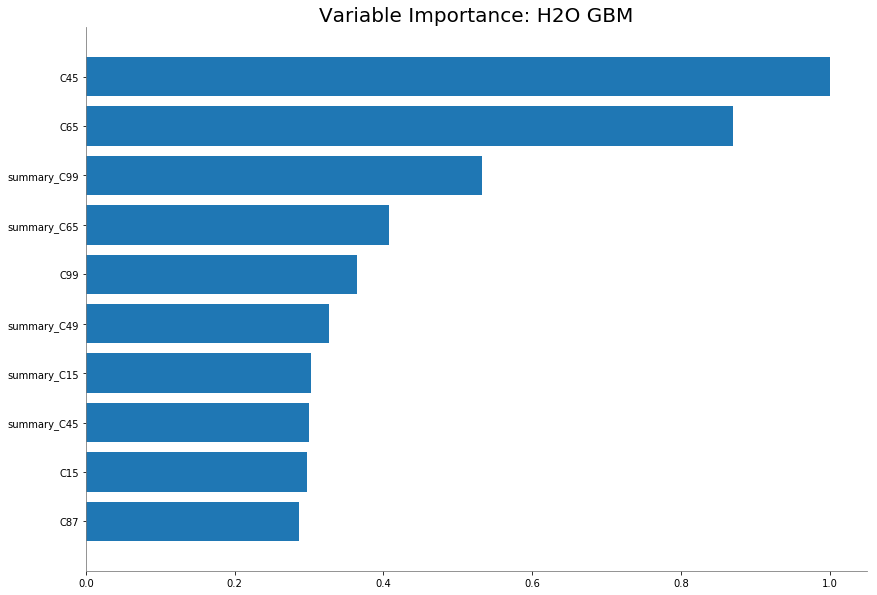

In [31]:
gbm.varimp_plot()

#### Partial Dependence Plot (PDP)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


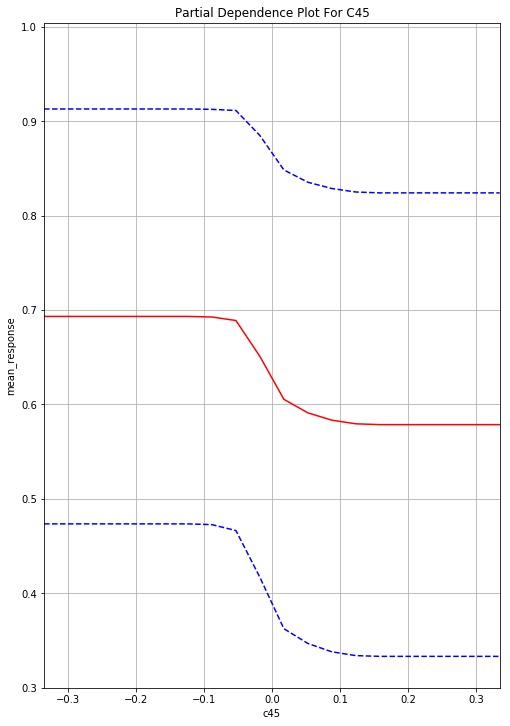

In [32]:
pdp_helpfulness = gbm.partial_plot(ext_train_new, cols = ['C45'])

#### Individual Conditional Expectation (ICE)

In [33]:
ext_test_simple_gice = ext_test_simple.sort('C45')

In [34]:
ext_test_simple_gices = h2o.H2OFrame(ext_test_simple_gice.as_data_frame().iloc[::15])

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [35]:
ext_test_simple_gices.shape

(558, 209)

In [36]:
C45_ice_df = ice(data=ext_test_simple_gices, column='C45', model=gbm)

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


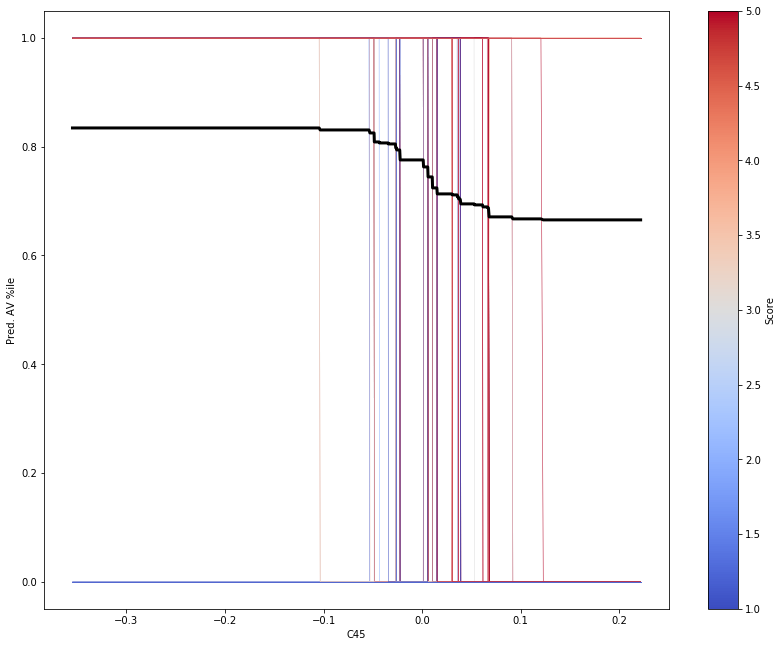

In [37]:
ice_plot(C45_ice_df, linewidth=0.5, color_by='Score', cmap='coolwarm',
        plot_pdp=True, pdp_kwargs={'c': 'k', 'linewidth': 3})
vals = C45_ice_df.columns.get_level_values('Score').values
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vals.min(), vmax=vals.max()))
sm._A = []
plt.colorbar(sm, label='Score')
plt.ylabel('Pred. AV %ile')
plt.xlabel('C45');

### 2.4.3 Matrix

In [38]:
print("AUC on validation data: " + str(round(gbm.auc(valid = True), 3)))

AUC on validation data: 0.847


In [39]:
gbm.confusion_matrix(valid=True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4600680081556039: 


,0,1,Error,Rate
0,2329.0,1883.0,0.4471,(1883.0/4212.0)
1,510.0,6430.0,0.0735,(510.0/6940.0)
Total,2839.0,8313.0,0.2146,(2393.0/11152.0)


In [40]:
gbm.r2(train=True, valid=True)

{'train': 0.4450081600704048, 'valid': 0.35888062454985814}

In [42]:
 h2o.cluster().shutdown()

H2O session _sid_9208 closed.
